# Bundestagsreden analysiert

Inspirierende Fragen: 
- Wer redet wie oft? 
- Wer bekommt wieviel Applaus? 
- Wer bekommt von wem Applaus? 
- Wer gibt wem besonders gerne Applaus?
- Wer wird wie oft unterbrochen? 
- Wer unterbricht besonders oft? 
- Wer wird von wem unterbrochen? 

- Wer redet über andere Parteien und Abgeordnete? 
- Wer wird besonders oft in anderen Reden erwähnt oder angesprochen?
- Über was wird geredet? 
- Wer redet über was? 

In [1900]:
#Plenarprotokolle stehen als xml-Dokumente zur Verfügung daher nutzen wir beautiful soup
from bs4 import BeautifulSoup
#Und weil wir uns die Datei direkt online abholen importieren wir urllib
import urllib
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt




### Plenarsitzung-Protokoll auslesen

In [1928]:
filesource = "https://www.bundestag.de/blob/580166/a0b286a19709f1d05a25641745e7a2e4/19065-data.xml"
#filesource = "https://www.bundestag.de/blob/578466/7430bccaf792e7bc55e84d5e64675820/19062-data.xml"
#filesource = "https://www.bundestag.de/blob/577958/e2063c0f51a32690a269f48aa6102c1d/19061-data.xml"
#filesource = "https://www.bundestag.de/blob/570844/20033ae97aaf30c4e492b8c49f538064/19052-data.xml"
#filesource = "https://www.bundestag.de/blob/553878/7bc843a98b9782c2babf74e853c26198/19029-data.xml"
#filesource = "https://www.bundestag.de/blob/543396/56cc6b4dac24ba9030170c178c68c953/19002-data.xml"
#filesource = "https://www.bundestag.de/blob/543388/e95b7194470ed3c4e8bca546dd0da950/19001-data.xml"

file = urllib.request.urlopen(filesource)
content = file.read()
soup = BeautifulSoup(content, "lxml")
#soup.prettify()

## Helper-Funktionen

In [1902]:
#kleiner Helper-funktion um Fraktionen zu sammeln. 
def getFraktionen(redner):
    fraktionen = []
    for r in redner: 
        if r.fraktion != None: 
            if r.fraktion.getText() not in fraktionen:
                fraktionen.append(r.fraktion.getText())
    return fraktionen
    

In [1927]:
#prüft welche Fraktion in einem text namentlich erwähnt wird. 
#gibt eine Liste zurück die alle erwähnten Fraktionen aufführt.
def fraktion_in(text, fraktionen): 
    fraktionInText = []
    for f in fraktionen: 
        if f in text:
            fraktionInText.append(f)
        #die Formulierung "Beifall im ganzen Haus" kommt immer wieder in Protokollen vor.  
        #hier wird jede Fraktion als Beifall-Spender notiert 
        elif "im ganzen Haus" in text: 
            fraktionInText.extend(fraktionen)
    
    return fraktionInText
    

In [1904]:
#sammelt in einer rede gezielte kommentare heraus. 
#sortiert nach fraktionen. Wird als Dictionary zurückgegeben
#Kommentare während einer Rede werden mit dem Tag <kommentar> im xml-Protokoll ausgezeichnet.
#Beifall: wird erkannt an Formulierungen aus dem Protokoll wie "Beifall von Abgeordneten der SPD"
#Zwischenrufe: alle anderen Kommentare werden als Zwischenrufe gezählt. Völlig Wertfrei, denn... 
#...der Inhalt, oder ob es sich um zustimmung oder ablehnung handelt, kann nicht erkannt werden. 
def getKommentare(rede, fraktionen):
    countBeifall = 0
    beifall = []
    countZwischenruf = 0
    zwischenrufe = []
    #jeden Kommentar durchlaufen
    kommentare = []
    for kom in rede('kommentar'):
        #in einem kommentar-tag sind oft mehrere Kommentare zusammengefasst.
        #sie werden durch einen gedankenstrich getrennt. das lösen wir hier auf. 
        if '\xa0–' in kom.text:
            list = kom.text.split('\xa0–')
            kommentare = kommentare + list
        else:
            kommentare.append(kom.text)

    
    for k in kommentare:
        text = k
         
        if 'Beifall' in text: 
            #Wie oft wird Beifall gespendet?
            countBeifall += 1
            #Von wem wird Beifall gespendet?
            freunde = fraktion_in(text, fraktionen)
            beifall = beifall + freunde
                
        else:
            #Wieviele Zwischenrufe gibt es? 
            countZwischenruf += 1
            #Von wem kommen die Zwischenrufe? 
            stoerer = fraktion_in(text, fraktionen)
            zwischenrufe = zwischenrufe + stoerer
            
    beifallVon = Counter(beifall)
    zwischenrufeVon = Counter(zwischenrufe)
            
    return {'beifall' : countBeifall, 
            'beifallAfD' : beifallVon['AfD'], 
            'beifallFDP' : beifallVon['FDP'], 
            'beifallLINKE' : beifallVon['LINKE'], 
            'beifallGRUEN' : beifallVon['DIE GRÜNEN'], 
            'beifallUNION' : beifallVon['CDU/CSU'], 
            'beifallSPD' : beifallVon['SPD'],
            'beifallVon' : beifall, 
            'zwischenrufe' : countZwischenruf,
            'zwischenrufeAfD' : zwischenrufeVon['AfD'],
            'zwischenrufeFDP' : zwischenrufeVon['FDP'],
            'zwischenrufeLINKE' : zwischenrufeVon['LINKE'],
            'zwischenrufeGRUEN' : zwischenrufeVon['DIE GRÜNEN'],
            'zwischenrufeUNION' : zwischenrufeVon['CDU/CSU'],
            'zwischenrufeSPD' : zwischenrufeVon['SPD'], 
            'ZwischenrufeVon' : zwischenrufe}

In [1905]:
def matchFraktion(bezeichnung):
    for f in fraktionen: 
        if f in bezeichnung:
            return f

## DataMining

### Reden bereinigen

In [1906]:
#reden = soup.find_all('rede')
reden = soup('rede')
redner = [rede('p', {'klasse' : 'redner'})[0] for rede in soup('rede')]
fraktionen = ['CDU/CSU', 'SPD', 'AfD', 'FDP', 'LINKE', 'DIE GRÜNEN', 'fraktionslos']
#fraktionen = getFraktionen(redner)

In [1907]:
#entferne Ansprachen des Sitzungspräsidenten und Reaktionen darauf.
#Innerhalb einer Rede spricht immer wieder auch der Sitzungspräsident
def cleanPresident(rede):
    kom = rede.p.find_next_siblings('name')
    nextredner = rede.p.find_next_sibling(klasse='redner')

    for k in kom:
        for sib in k.next_siblings: 
            if sib in kom: 
                break
            elif sib == nextredner:
                break
            else: 
                try: sib.clear()
                except: i=1

In [1908]:
#Wortmeldungen (!= Zwischenrufe) anderer Redner innerhalb einer rede werden entfernt
def cleanRedner(rede): 
    redner = rede.find(klasse='redner')
    allredner = rede.find_all(klasse='redner')
    
    if len(allredner) != 1:  
        for r in allredner:
            if r != redner:
                for sib in r.next_siblings:
                    if sib in allredner:
                        break
                    else:
                        try: sib.clear()
                        except: i=1
    

### DataFrame erstellen

In [1909]:
#DataFrame anlegen 
df = pd.DataFrame(columns=['redner', 'fraktion', 'beifall', 'beifallAfD', 'beifallFDP', 'beifallLINKE', 'beifallGRUEN', 
                           'beifallUNION', 'beifallSPD', 'beifallVon', 'zwischenrufe', 'zwischenrufeAfD', 
                           'zwischenrufeFDP', 'zwischenrufeLINKE', 'zwischenrufeGRUEN', 'zwischenrufeUNION', 
                           'zwischenrufeSPD', 'zwischenrufeVon'])

In [1910]:
i = 0
#Alle reden durchlaufen
while i < len(reden):
    #stammdaten herausarbeiten
    cleanPresident(reden[i])
    cleanRedner(reden[i])
    kom = getKommentare(reden[i], fraktionen)
    name = ""
    frak = "k.A."
    redeID = reden[i].get('id')
    r = redner[i]
    if r.vorname != None:
        name = name + r.vorname.getText()
    if r.nachname != None:
        name = name + " " + r.nachname.getText()
    if r.fraktion != None:    
        frak = matchFraktion(r.fraktion.getText())
    
    
    #Daten ins DataFrame schreiben    
    df.loc[redeID] = [name, frak, kom['beifall'], 
                      kom['beifallAfD'], 
                      kom['beifallFDP'], 
                      kom['beifallLINKE'], 
                      kom['beifallGRUEN'],
                      kom['beifallUNION'], 
                      kom['beifallSPD'],
                      kom['beifallVon'], 
                      kom['zwischenrufe'], 
                      kom['zwischenrufeAfD'], 
                      kom['zwischenrufeFDP'], 
                      kom['zwischenrufeLINKE'], 
                      kom['zwischenrufeGRUEN'],
                      kom['zwischenrufeUNION'], 
                      kom['zwischenrufeSPD'], 
                      kom['ZwischenrufeVon'] ]
    i += 1


In [1935]:
df

,redner,fraktion,beifall,beifallAfD,beifallFDP,beifallLINKE,beifallGRUEN,beifallUNION,beifallSPD,beifallVon,zwischenrufe,zwischenrufeAfD,zwischenrufeFDP,zwischenrufeLINKE,zwischenrufeGRUEN,zwischenrufeUNION,zwischenrufeSPD,zwischenrufeVon
ID192900100,Andrea Nahles,SPD,11,19,20,20,19,21,23,"[CDU/CSU, SPD, AfD, FDP, LINKE, DIE GRÜNEN, CD...",1,0,0,0,0,0,0,[]
ID192900200,Alexander Gauland,AfD,6,6,0,0,0,0,0,"[AfD, AfD, AfD, AfD, AfD, AfD]",2,1,0,0,0,0,0,[AfD]
ID192900300,Volker Kauder,CDU/CSU,14,30,36,35,35,38,36,"[CDU/CSU, CDU/CSU, SPD, AfD, FDP, LINKE, DIE G...",5,4,0,0,0,0,0,"[AfD, AfD, AfD, AfD]"
ID192900400,Alexander Graf Lambsdorff,FDP,5,3,5,0,2,4,1,"[CDU/CSU, SPD, AfD, FDP, DIE GRÜNEN, CDU/CSU, ...",8,0,1,2,5,0,0,"[DIE GRÜNEN, DIE GRÜNEN, LINKE, DIE GRÜNEN, DI..."
ID192900500,Dietmar Bartsch,LINKE,15,1,5,15,11,6,12,"[SPD, LINKE, DIE GRÜNEN, SPD, LINKE, DIE GRÜNE...",3,0,0,0,0,2,0,"[CDU/CSU, CDU/CSU]"
ID192900600,Katrin Göring-Eckardt,DIE GRÜNEN,9,3,7,8,9,6,6,"[CDU/CSU, SPD, FDP, LINKE, DIE GRÜNEN, CDU/CSU...",3,2,0,0,0,0,0,"[AfD, AfD]"
ID192900700,Christian Schmidt,CDU/CSU,4,3,2,0,2,4,2,"[CDU/CSU, CDU/CSU, AfD, DIE GRÜNEN, CDU/CSU, S...",2,0,0,1,0,0,0,[LINKE]
ID192900800,Beatrix von Storch,AfD,7,7,0,0,0,0,0,"[AfD, AfD, AfD, AfD, AfD, AfD, AfD]",8,1,0,0,3,2,2,"[SPD, DIE GRÜNEN, SPD, DIE GRÜNEN, DIE GRÜNEN,..."
ID192900900,Martin Schulz,SPD,3,3,3,3,3,3,3,"[CDU/CSU, SPD, AfD, FDP, LINKE, DIE GRÜNEN, CD...",1,0,0,0,0,0,0,[]
ID192901000,Bijan Djir-Sarai,FDP,4,3,4,1,2,3,2,"[FDP, CDU/CSU, SPD, AfD, FDP, LINKE, DIE GRÜNE...",0,0,0,0,0,0,0,[]


## Auswertung

In [1911]:
#Counter(df.loc['ID195200200', 'beifallVon'])

In [1912]:
df['beifall'].max()

16

In [1913]:
# wie oft bekommt xy beifall? 
df['beifall'][df['fraktion']=='CDU/CSU'].sum()

191

In [1914]:
df['beifallUNION'][df['fraktion']=='CDU/CSU'].sum()

202

### Wieviele Zwischenrufe werden verursacht

In [1915]:
# wieviele zwischenrufe werden durch xy verursacht
#fraktionen = ['CDU/CSU', 'SPD', 'AfD', 'FDP', 'LINKE', 'DIE GRÜNEN', 'fraktionslos']
arrRufe=[]
arrRufe.append(df['zwischenrufeUNION'].sum())
arrRufe.append(df['zwischenrufeSPD'].sum())
arrRufe.append(df['zwischenrufeAfD'].sum())
arrRufe.append(df['zwischenrufeFDP'].sum())
arrRufe.append(df['zwischenrufeLINKE'].sum())
arrRufe.append(df['zwischenrufeGRUEN'].sum())
arrRufe.append(0)
arrRufe

[155, 91, 142, 104, 119, 139, 0]

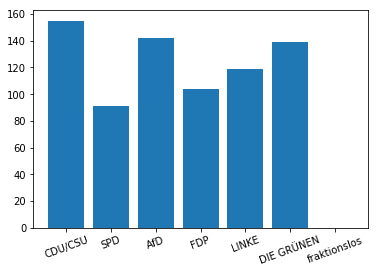

In [1937]:
# plotten wir das zeug mal als barchart
xs = [i for i, _ in enumerate(fraktionen)]
plt.bar(xs, arrRufe)
plt.xticks([i for i, _ in enumerate(fraktionen)], fraktionen, rotation=20)
plt.show()

### Wer ruft bei wem dazwischen? 

In [1917]:
zwischenrufeDF = pd.DataFrame(columns=fraktionen, dtype=float)

In [1918]:
zwischenrufeVonUnion = df.groupby('fraktion')['zwischenrufeUNION'].sum()
zwischenrufeVonSPD= df.groupby('fraktion')['zwischenrufeSPD'].sum()
zwischenrufeVonAfD = df.groupby('fraktion')['zwischenrufeAfD'].sum()
zwischenrufeVonFDP = df.groupby('fraktion')['zwischenrufeFDP'].sum()
zwischenrufeVonLINKE = df.groupby('fraktion')['zwischenrufeLINKE'].sum()
zwischenrufeVonGRUEN = df.groupby('fraktion')['zwischenrufeGRUEN'].sum()
i=0
for f in zwischenrufeVonUnion.keys(): 
    zwischenrufeDF.loc['CDU/CSU', f] = zwischenrufeVonUnion.values[i]
    zwischenrufeDF.loc['SPD', f] = zwischenrufeVonSPD.values[i]
    zwischenrufeDF.loc['AfD', f] = zwischenrufeVonAfD.values[i]
    zwischenrufeDF.loc['FDP', f] = zwischenrufeVonFDP.values[i]
    zwischenrufeDF.loc['LINKE', f] = zwischenrufeVonLINKE.values[i]
    zwischenrufeDF.loc['GRUEN', f] = zwischenrufeVonGRUEN.values[i]
    i += 1

In [1919]:
# Zeile: Macht Zwischenrufe bei <Spalte> 
zwischenrufeDF.values
zwischenrufeDF.drop('fraktionslos', axis=1, inplace=True)
zwischenrufeDF.drop('k.A.', axis=1, inplace=True)
zwischenrufeDF

,CDU/CSU,SPD,AfD,FDP,LINKE,DIE GRÜNEN
CDU/CSU,16.0,33.0,65.0,16.0,11.0,13.0
SPD,6.0,12.0,46.0,9.0,6.0,8.0
AfD,49.0,44.0,8.0,10.0,18.0,13.0
FDP,32.0,25.0,17.0,6.0,12.0,10.0
LINKE,28.0,10.0,48.0,17.0,7.0,5.0
GRUEN,36.0,16.0,67.0,12.0,4.0,4.0


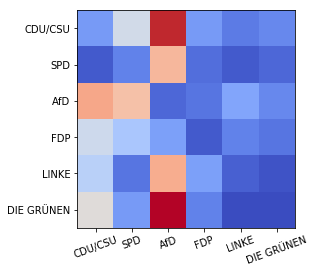

In [1936]:
plt.imshow(zwischenrufeDF.values, cmap='coolwarm', interpolation='nearest')
plt.xticks([i for i, _ in enumerate(zwischenrufeDF.keys())], zwischenrufeDF.keys(), rotation=20)
plt.yticks([i for i, _ in enumerate(zwischenrufeDF.keys())], zwischenrufeDF.keys())
plt.show()

### Wer redet wie oft?

In [1921]:
# Wer redet wie oft? 
vcount = df['fraktion'].value_counts()

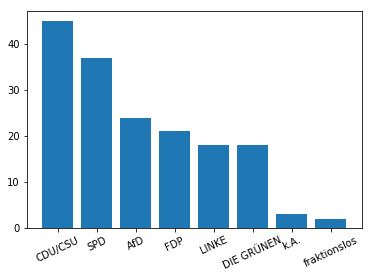

In [1939]:
#plot als barchart
xs = [i + 0.5 for i, _ in enumerate(vcount.keys())]
plt.bar(xs, vcount.values)
plt.xticks([i + 0.5 for i, _ in enumerate(vcount.keys())], vcount.keys(), rotation=25)
plt.show()


### Beifall und Applaus

In [1923]:
beifallDF = pd.DataFrame(columns=fraktionen, dtype=float)

In [1924]:
beifallVonUnion = df.groupby('fraktion')['beifallUNION'].sum()
beifallVonSPD= df.groupby('fraktion')['beifallSPD'].sum()
beifallVonAfD = df.groupby('fraktion')['beifallAfD'].sum()
beifallVonFDP = df.groupby('fraktion')['beifallFDP'].sum()
beifallVonLINKE = df.groupby('fraktion')['beifallLINKE'].sum()
beifallVonGRUEN = df.groupby('fraktion')['beifallGRUEN'].sum()
i=0
for f in beifallVonUnion.keys(): 
    beifallDF.loc['CDU/CSU', f] = beifallVonUnion.values[i]
    beifallDF.loc['SPD', f] = beifallVonSPD.values[i]
    beifallDF.loc['AfD', f] = beifallVonAfD.values[i]
    beifallDF.loc['FDP', f] = beifallVonFDP.values[i]
    beifallDF.loc['LINKE', f] = beifallVonLINKE.values[i]
    beifallDF.loc['GRUEN', f] = beifallVonGRUEN.values[i]
    i += 1

In [1925]:
# Zeile: Gibt Applaus an <Spalte> 
beifallDF.values
beifallDF.drop('fraktionslos', axis=1, inplace=True)
beifallDF.drop('k.A.', axis=1, inplace=True)
beifallDF

,CDU/CSU,SPD,AfD,FDP,LINKE,DIE GRÜNEN
CDU/CSU,202.0,91.0,0.0,54.0,16.0,23.0
SPD,134.0,215.0,1.0,35.0,43.0,47.0
AfD,38.0,23.0,152.0,13.0,1.0,4.0
FDP,110.0,66.0,0.0,123.0,17.0,31.0
LINKE,58.0,73.0,0.0,19.0,142.0,62.0
GRUEN,72.0,86.0,0.0,33.0,55.0,113.0


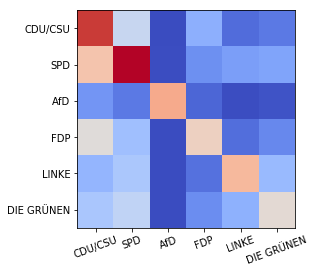

In [1940]:
plt.imshow(beifallDF.values, cmap='coolwarm', interpolation='nearest')
plt.xticks([i for i, _ in enumerate(beifallDF.keys())], beifallDF.keys(), rotation=20)
plt.yticks([i for i, _ in enumerate(beifallDF.keys())], beifallDF.keys())
plt.show()